# Machine Learning Assignment 2

Amiru Chandrasena & Kelvin Young

# Classifying Cells Bassed On Type

The Cells Dataset contains two components, one component is the CSV document containing the features about the cell and the cells corresponding image url. Secondly there is also a folder of images on cells in PNG format

# [1] Reading In The Data

The first step of data analysis is reading in the data from the CSV file, secondly the next step is exploring the data to look for errors and tredns in the dataset that may help with optimising the approach and the model.

In [91]:
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
dataSet_cells = pd.read_csv('data/data_labels_mainData.csv')


## [1.1] Exploring The Data

Exploring the data involves firstly checking the head and the tail of the data to ensure that the CSV file has been compleately read in without errors. This includes checking the first couple of records, the last records and the features. Secondly the next step is to check for missing values to ensure that the model is not introduced to incomplete data and interfearing with the performance of the model.  

In [92]:
dataSet_cells.head(10)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0
5,22410,1,22410.png,fibroblast,0,0
6,22411,1,22411.png,fibroblast,0,0
7,22412,1,22412.png,fibroblast,0,0
8,22413,1,22413.png,fibroblast,0,0
9,22414,1,22414.png,fibroblast,0,0


In [93]:
dataSet_cells.tail(10)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
9886,1616,60,1616.png,epithelial,2,1
9887,1617,60,1617.png,epithelial,2,1
9888,1618,60,1618.png,epithelial,2,1
9889,1619,60,1619.png,epithelial,2,1
9890,1624,60,1624.png,epithelial,2,1
9891,1625,60,1625.png,epithelial,2,1
9892,1626,60,1626.png,epithelial,2,1
9893,1627,60,1627.png,epithelial,2,1
9894,1628,60,1628.png,epithelial,2,1
9895,1629,60,1629.png,epithelial,2,1


In [94]:
dataSet_cells.tail(10)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
9886,1616,60,1616.png,epithelial,2,1
9887,1617,60,1617.png,epithelial,2,1
9888,1618,60,1618.png,epithelial,2,1
9889,1619,60,1619.png,epithelial,2,1
9890,1624,60,1624.png,epithelial,2,1
9891,1625,60,1625.png,epithelial,2,1
9892,1626,60,1626.png,epithelial,2,1
9893,1627,60,1627.png,epithelial,2,1
9894,1628,60,1628.png,epithelial,2,1
9895,1629,60,1629.png,epithelial,2,1


In [95]:
null_counts = dataSet_cells.isnull().sum()

print(null_counts)

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64


In [96]:
dataSet_cells.describe()

,InstanceID,patientID,cellType,isCancerous
count,9896.000000,9896.000000,9896.000000,9896.000000
mean,10193.880154,29.762025,1.501516,0.412187
std,6652.912660,17.486553,0.954867,0.492253
min,1.000000,1.000000,0.000000,0.000000
25%,4135.750000,14.000000,1.000000,0.000000
50%,9279.500000,26.000000,2.000000,0.000000
75%,16821.250000,47.000000,2.000000,1.000000
max,22444.000000,60.000000,3.000000,1.000000


In [97]:
dataSet_cells.dtypes

InstanceID       int64
patientID        int64
ImageName       object
cellTypeName    object
cellType         int64
isCancerous      int64
dtype: object

## [1.2] Stripping Features 

It is importnat to drop unimportant fatures from the dataset for example 'InstanceID', 'patientID' ..etc are irrelevant to the training of the model. THe only important information that is used if the numeric column called 'cellType' that assigns a numeric value to the 'cellTypeName' attributes and the 'ImageName'. 

In [98]:
import pandas as pd

# Drop the specified features
dataSet_cells.drop(["InstanceID", "patientID", "cellTypeName", "isCancerous"], axis=1, inplace=True)
dataSet_cells.head()

,ImageName,cellType
0,22405.png,0
1,22406.png,0
2,22407.png,0
3,22408.png,0
4,22409.png,0


## [1.3] Splitting The Dataset Into Training, Validaiton and Testing Sets

Splitting the dataset into the three section allows for the effecive testing of the dataset. Allocating 80%(5937) of the dataset to the the training of the model allows for th emodel to have an increased accuracy, while allowin for the validation set to test the accuracy of the model without exposing it to the final test data leaving it unseen. The validation set allows for the base models accuracy to be gauged allowing infromation about the model to be taken such as if its overfitted or underfitted and what possible hyperparameters need to be changed. 

We then use a histogram to check the distribution of train set attributes is approximately equal to the distribution of test set attributes. This is important for the following reasons:

Generalisation: By ensuring that the data is a fair sample of the the whole dataset for bot hthe validaiton and the test set, you increase the likelihood that the model will be able to generalise well to unseen data. If the test set has a significantly different distribution, the model may struggle to make accurate predictions because it hasn't learned the relevant patterns or variations during training. Further there can be bias as the data in the validation set may skew one way and not be representing of the whole dataset. 

Ultimately this helps in building a robust and reliable model that can generalize well to unseen data.

Train data : (5937, 2), Val Data: (1979, 2), Test Data: (1980, 2)


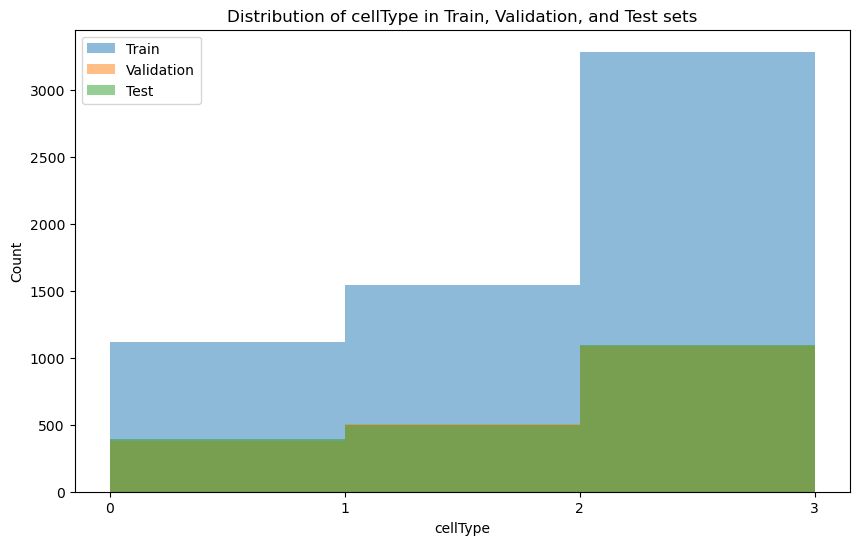

In [99]:
# We split the data into 80% of training Data, 10% Validation and 10% Testing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


train_data, test_data = train_test_split(dataSet_cells, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape, val_data.shape, test_data.shape))

# Plot histogram for train set
plt.figure(figsize=(10, 6))
plt.hist(train_data['cellType'], bins=range(4), alpha=0.5, label='Train')
plt.hist(val_data['cellType'], bins=range(4), alpha=0.5, label='Validation')
plt.hist(test_data['cellType'], bins=range(4), alpha=0.5, label='Test')
plt.xlabel('cellType')
plt.ylabel('Count')
plt.title('Distribution of cellType in Train, Validation, and Test sets')
plt.xticks(range(4))
plt.legend()
plt.show()


The graph above shows the spread of data and we see that the validation adn test set are very similar and representative of the whole dataset.

# [2] Model Development

## [2.1] Base Model

The base model begins with defining the dimensions of the image with (16*16*3) turinnig this into an array, secondly the hidden layer defines 256 neurons to start which will be tunned later to ensure that the model is working effectively. Thirdly as there are 4 different types of cells there will be 4 different output classes.

In [100]:
INPUT_DIM = (16,16,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

## [2.2] Create a sequential API to build the model

There are three different types of models in tensorflow and the Sequential model was used for this NN as it is simplistic in the manner it works allowsing for models to be built layer by layer and the simplicity for it to be trained. 

The three layers were used in the model as first the image is flattend as mentioned in the previous cell, there will be no learning done in the layer and only image processing. THe second layer is responsible for the learning as it uses a sigmoid acitvation. THen the final layer is responcible for the output of the results. 

In [139]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM), ## Flatten the images into (16x16x3) array
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])
model.summary()

Model: "sequential_208"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_208 (Flatten)       (None, 768)               0         
                                                                 
 dense_416 (Dense)           (None, 256)               196864    
                                                                 
 dense_417 (Dense)           (None, 4)                 1028      
                                                                 
Total params: 197,892
Trainable params: 197,892
Non-trainable params: 0
_________________________________________________________________


In the code above, tf.keras.regularizers.l2(0.01) is used to apply L2 regularization with a regularization parameter of 0.01 to the weights of the Dense layer

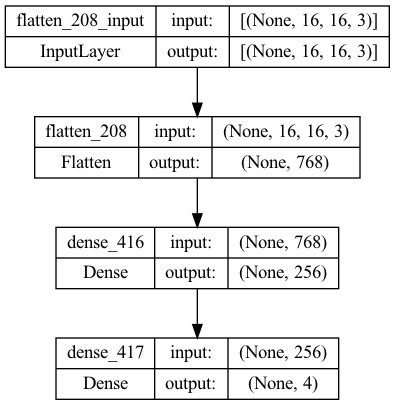

In [140]:
tf.keras.utils.plot_model(model, show_shapes=True)

## [2.3] Compiling The Model

In [141]:
model.compile(optimizer='SGD', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['categorical_accuracy'])


Change the feature title to a string 

In [142]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

## [2.4] Image Generation 

Systematically load in the data 

Preprocessing: Preprocess your images as needed to make them suitable for training with a feedforward neural network. This may involve resizing the images to a fixed size and converting them to a suitable format (e.g., grayscale or RGB channels).


In [105]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(16, 16),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(16, 16),
        batch_size=batch_size,
        class_mode='categorical')


Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


## [2.5] Fitting & Training The Model

Now Training the model

In [106]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=50, verbose=0)


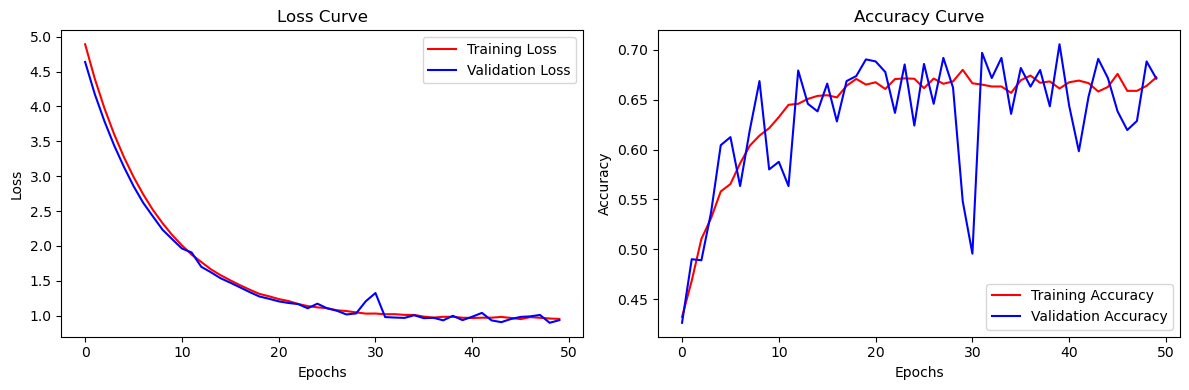

62/62 [==============================] - 1s 16ms/step - loss: 1.5029 - categorical_accuracy: 0.2562
Test Loss: 1.5029343366622925
Test Accuracy: 0.2561900019645691


In [143]:
import matplotlib.pyplot as plt

def plot_learning_curve(train_loss, val_loss, train_acc, val_acc, metric_name='Accuracy'):
    # Plotting the Loss Curve
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, 'r-', label='Training Loss')
    plt.plot(val_loss, 'b-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Plotting the Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, 'r-', label='Training ' + metric_name)
    plt.plot(val_acc, 'b-', label='Validation ' + metric_name)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the learning curves
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

# Evaluate the model on the validation data
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


On the other hand, the spiky behavior of the validation loss suggests that the model is not generalizing well to unseen data. It indicates that the model's performance on the validation set is inconsistent and fluctuates significantly during training. This could be a sign of overfitting, where the model is learning to fit the training data too closely and struggles to generalize to new examples

The spikier and increasing trend of the training accuracy compared to the first graph could be an indication that the model is memorizing the training data, leading to high accuracy on the training set but poor generalization to new examples.

If the model is over fitting:
Regularization (Lasso/Ridge penalty): Regularization techniques like L1 (Lasso) and L2 (Ridge) regularization can help control the complexity of the model by adding a penalty term to the loss function. This penalty discourages large weights and encourages the model to learn simpler and more generalizable representations. You can experiment with different regularization strengths to find the right balance between reducing overfitting and preserving model performance.

Dropout: Dropout is a regularization technique where randomly selected neurons are temporarily "dropped out" during training. This helps prevent the model from relying too heavily on specific neurons and encourages the network to learn more robust and generalized features. Dropout introduces some level of randomness and acts as an ensemble of multiple sub-networks during training, reducing overfitting.

Reduce the number of neurons or layers: Simplifying the model architecture by reducing the number of neurons or layers can help reduce overfitting. A complex model with a large number of parameters is more prone to overfitting, especially if the training data is limited. By reducing the model's capacity, you can encourage it to learn more generalized patterns and reduce the risk of overfitting.

plus use scaling 

# Tuned Hyperparameters

In [108]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define the hyperparameters and their value ranges to search
param_dist = {
    'learning_rate': uniform(0.001, 0.1),
    'epochs': [50, 100, 200],
    'hidden_layer_dim': [128, 256, 512],
}

# Define a function to create the model
def create_model(learning_rate, epochs, hidden_layer_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=INPUT_DIM),
        tf.keras.layers.Dense(hidden_layer_dim, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(OUTPUT_CLASSES)
    ])
    model.compile(optimizer='SGD', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['categorical_accuracy'])
    return model

# Create the model instance
model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model)

# Get the input images and target labels from the train_generator
X_train, y_train = train_generator.next()

# Perform random search with cross-validation
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, cv=3, n_iter=10)
random_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters: ", random_search.best_params_)


Epoch 1/200


/var/folders/vv/b8ymkr314zndgy47s502245w0000gn/T/ipykernel_46883/2830404001.py:22: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model)


1/1 [==============================] - 0s 305ms/step - loss: 3.7279 - categorical_accuracy: 0.4286
Epoch 2/200
1/1 [==============================] - 0s 3ms/step - loss: 3.6725 - categorical_accuracy: 0.4286
Epoch 3/200
1/1 [==============================] - 0s 4ms/step - loss: 3.6262 - categorical_accuracy: 0.4286
Epoch 4/200
1/1 [==============================] - 0s 3ms/step - loss: 3.5877 - categorical_accuracy: 0.4286
Epoch 5/200
1/1 [==============================] - 0s 4ms/step - loss: 3.5558 - categorical_accuracy: 0.4286
Epoch 6/200
1/1 [==============================] - 0s 3ms/step - loss: 3.5297 - categorical_accuracy: 0.4286
Epoch 7/200
1/1 [==============================] - 0s 3ms/step - loss: 3.5085 - categorical_accuracy: 0.4286
Epoch 8/200
1/1 [==============================] - 0s 3ms/step - loss: 3.4915 - categorical_accuracy: 0.4286
Epoch 9/200
1/1 [==============================] - 0s 4ms/step - loss: 3.4779 - categorical_accuracy: 0.4286
Epoch 10/200
1/1 [===========

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


1/1 [==============================] - 0s 436ms/step - loss: 3.5738 - categorical_accuracy: 0.2381
Epoch 2/200
1/1 [==============================] - 0s 4ms/step - loss: 3.5634 - categorical_accuracy: 0.2857
Epoch 3/200
1/1 [==============================] - 0s 5ms/step - loss: 3.5562 - categorical_accuracy: 0.2381
Epoch 4/200
1/1 [==============================] - 0s 5ms/step - loss: 3.5509 - categorical_accuracy: 0.2857
Epoch 5/200
1/1 [==============================] - 0s 5ms/step - loss: 3.5469 - categorical_accuracy: 0.3333
Epoch 6/200
1/1 [==============================] - 0s 5ms/step - loss: 3.5437 - categorical_accuracy: 0.4286
Epoch 7/200
1/1 [==============================] - 0s 6ms/step - loss: 3.5409 - categorical_accuracy: 0.3810
Epoch 8/200
1/1 [==============================] - 0s 7ms/step - loss: 3.5385 - categorical_accuracy: 0.4286
Epoch 9/200
1/1 [==============================] - 0s 6ms/step - loss: 3.5363 - categorical_accuracy: 0.3810
Epoch 10/200
1/1 [===========

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


1/1 [==============================] - 1s 668ms/step - loss: 3.8702 - categorical_accuracy: 0.1818
Epoch 2/200
1/1 [==============================] - 0s 6ms/step - loss: 3.7012 - categorical_accuracy: 0.1818
Epoch 3/200
1/1 [==============================] - 0s 9ms/step - loss: 3.5975 - categorical_accuracy: 0.2273
Epoch 4/200
1/1 [==============================] - 0s 8ms/step - loss: 3.5359 - categorical_accuracy: 0.4091
Epoch 5/200
1/1 [==============================] - 0s 7ms/step - loss: 3.4994 - categorical_accuracy: 0.4545
Epoch 6/200
1/1 [==============================] - 0s 6ms/step - loss: 3.4773 - categorical_accuracy: 0.4545
Epoch 7/200
1/1 [==============================] - 0s 7ms/step - loss: 3.4634 - categorical_accuracy: 0.4545
Epoch 8/200
1/1 [==============================] - 0s 6ms/step - loss: 3.4541 - categorical_accuracy: 0.4545
Epoch 9/200
1/1 [==============================] - 0s 9ms/step - loss: 3.4477 - categorical_accuracy: 0.4545
Epoch 10/200
1/1 [===========

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


1/1 [==============================] - 0s 305ms/step - loss: 8.8345 - categorical_accuracy: 0.0952
Epoch 2/50
1/1 [==============================] - 0s 4ms/step - loss: 7.8603 - categorical_accuracy: 0.0952
Epoch 3/50
1/1 [==============================] - 0s 4ms/step - loss: 7.5550 - categorical_accuracy: 0.1429
Epoch 4/50
1/1 [==============================] - 0s 6ms/step - loss: 7.4617 - categorical_accuracy: 0.4286
Epoch 5/50
1/1 [==============================] - 0s 4ms/step - loss: 7.4320 - categorical_accuracy: 0.4286
Epoch 6/50
1/1 [==============================] - 0s 4ms/step - loss: 7.4195 - categorical_accuracy: 0.4286
Epoch 7/50
1/1 [==============================] - 0s 4ms/step - loss: 7.4122 - categorical_accuracy: 0.4286
Epoch 8/50
1/1 [==============================] - 0s 4ms/step - loss: 7.4068 - categorical_accuracy: 0.4286
Epoch 9/50
1/1 [==============================] - 0s 5ms/step - loss: 7.4023 - categorical_accuracy: 0.4286
Epoch 10/50
1/1 [====================

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


1/1 [==============================] - 1s 632ms/step - loss: 7.6580 - categorical_accuracy: 0.1905
Epoch 2/50
1/1 [==============================] - 0s 5ms/step - loss: 7.5599 - categorical_accuracy: 0.2381
Epoch 3/50
1/1 [==============================] - 0s 4ms/step - loss: 7.5187 - categorical_accuracy: 0.2857
Epoch 4/50
1/1 [==============================] - 0s 4ms/step - loss: 7.5022 - categorical_accuracy: 0.1905
Epoch 5/50
1/1 [==============================] - 0s 4ms/step - loss: 7.4947 - categorical_accuracy: 0.3333
Epoch 6/50
1/1 [==============================] - 0s 5ms/step - loss: 7.4899 - categorical_accuracy: 0.2857
Epoch 7/50
1/1 [==============================] - 0s 4ms/step - loss: 7.4860 - categorical_accuracy: 0.3333
Epoch 8/50
1/1 [==============================] - 0s 4ms/step - loss: 7.4822 - categorical_accuracy: 0.3333
Epoch 9/50
1/1 [==============================] - 0s 4ms/step - loss: 7.4785 - categorical_accuracy: 0.3333
Epoch 10/50
1/1 [====================

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


1/1 [==============================] - 0s 286ms/step - loss: 7.9198 - categorical_accuracy: 0.0909
Epoch 2/50
1/1 [==============================] - 0s 4ms/step - loss: 7.5435 - categorical_accuracy: 0.3182
Epoch 3/50
1/1 [==============================] - 0s 4ms/step - loss: 7.4390 - categorical_accuracy: 0.4545
Epoch 4/50
1/1 [==============================] - 0s 4ms/step - loss: 7.4077 - categorical_accuracy: 0.4545
Epoch 5/50
1/1 [==============================] - 0s 4ms/step - loss: 7.3950 - categorical_accuracy: 0.4545
Epoch 6/50
1/1 [==============================] - 0s 5ms/step - loss: 7.3874 - categorical_accuracy: 0.4545
Epoch 7/50
1/1 [==============================] - 0s 4ms/step - loss: 7.3819 - categorical_accuracy: 0.4545
Epoch 8/50
1/1 [==============================] - 0s 4ms/step - loss: 7.3772 - categorical_accuracy: 0.4545
Epoch 9/50
1/1 [==============================] - 0s 4ms/step - loss: 7.3731 - categorical_accuracy: 0.4545
Epoch 10/50
1/1 [====================

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


1/1 [==============================] - 0s 279ms/step - loss: 4.1988 - categorical_accuracy: 0.1905
Epoch 2/50
1/1 [==============================] - 0s 3ms/step - loss: 3.9369 - categorical_accuracy: 0.1905
Epoch 3/50
1/1 [==============================] - 0s 3ms/step - loss: 3.7645 - categorical_accuracy: 0.1905
Epoch 4/50
1/1 [==============================] - 0s 3ms/step - loss: 3.6534 - categorical_accuracy: 0.1905
Epoch 5/50
1/1 [==============================] - 0s 3ms/step - loss: 3.5815 - categorical_accuracy: 0.1905
Epoch 6/50
1/1 [==============================] - 0s 4ms/step - loss: 3.5344 - categorical_accuracy: 0.1905
Epoch 7/50
1/1 [==============================] - 0s 4ms/step - loss: 3.5032 - categorical_accuracy: 0.2381
Epoch 8/50
1/1 [==============================] - 0s 3ms/step - loss: 3.4823 - categorical_accuracy: 0.3810
Epoch 9/50
1/1 [==============================] - 0s 3ms/step - loss: 3.4681 - categorical_accuracy: 0.3810
Epoch 10/50
1/1 [====================

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


1/1 [==============================] - 0s 277ms/step - loss: 3.9744 - categorical_accuracy: 0.2857
Epoch 2/50
1/1 [==============================] - 0s 3ms/step - loss: 3.8402 - categorical_accuracy: 0.2857
Epoch 3/50
1/1 [==============================] - 0s 3ms/step - loss: 3.7500 - categorical_accuracy: 0.2857
Epoch 4/50
1/1 [==============================] - 0s 3ms/step - loss: 3.6888 - categorical_accuracy: 0.2857
Epoch 5/50
1/1 [==============================] - 0s 4ms/step - loss: 3.6471 - categorical_accuracy: 0.2857
Epoch 6/50
1/1 [==============================] - 0s 3ms/step - loss: 3.6188 - categorical_accuracy: 0.2857
Epoch 7/50
1/1 [==============================] - 0s 3ms/step - loss: 3.5994 - categorical_accuracy: 0.2857
Epoch 8/50
1/1 [==============================] - 0s 4ms/step - loss: 3.5863 - categorical_accuracy: 0.2857
Epoch 9/50
1/1 [==============================] - 0s 3ms/step - loss: 3.5772 - categorical_accuracy: 0.2857
Epoch 10/50
1/1 [====================

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


1/1 [==============================] - 0s 280ms/step - loss: 3.5633 - categorical_accuracy: 0.2727
Epoch 2/50
1/1 [==============================] - 0s 3ms/step - loss: 3.5207 - categorical_accuracy: 0.5000
Epoch 3/50
1/1 [==============================] - 0s 3ms/step - loss: 3.4926 - categorical_accuracy: 0.4545
Epoch 4/50
1/1 [==============================] - 0s 3ms/step - loss: 3.4737 - categorical_accuracy: 0.4545
Epoch 5/50
1/1 [==============================] - 0s 4ms/step - loss: 3.4607 - categorical_accuracy: 0.4545
Epoch 6/50
1/1 [==============================] - 0s 3ms/step - loss: 3.4515 - categorical_accuracy: 0.4545
Epoch 7/50
1/1 [==============================] - 0s 3ms/step - loss: 3.4447 - categorical_accuracy: 0.4545
Epoch 8/50
1/1 [==============================] - 0s 4ms/step - loss: 3.4394 - categorical_accuracy: 0.4545
Epoch 9/50
1/1 [==============================] - 0s 3ms/step - loss: 3.4351 - categorical_accuracy: 0.4545
Epoch 10/50
1/1 [====================

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


1/1 [==============================] - 0s 277ms/step - loss: 3.7112 - categorical_accuracy: 0.1905
Epoch 2/50
1/1 [==============================] - 0s 3ms/step - loss: 3.6248 - categorical_accuracy: 0.1905
Epoch 3/50
1/1 [==============================] - 0s 3ms/step - loss: 3.5661 - categorical_accuracy: 0.4286
Epoch 4/50
1/1 [==============================] - 0s 3ms/step - loss: 3.5263 - categorical_accuracy: 0.4286
Epoch 5/50
1/1 [==============================] - 0s 3ms/step - loss: 3.4988 - categorical_accuracy: 0.4286
Epoch 6/50
1/1 [==============================] - 0s 4ms/step - loss: 3.4795 - categorical_accuracy: 0.4286
Epoch 7/50
1/1 [==============================] - 0s 4ms/step - loss: 3.4656 - categorical_accuracy: 0.4286
Epoch 8/50
1/1 [==============================] - 0s 3ms/step - loss: 3.4553 - categorical_accuracy: 0.4286
Epoch 9/50
1/1 [==============================] - 0s 3ms/step - loss: 3.4476 - categorical_accuracy: 0.4286
Epoch 10/50
1/1 [====================

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


1/1 [==============================] - 0s 281ms/step - loss: 3.5851 - categorical_accuracy: 0.3333
Epoch 2/50
1/1 [==============================] - 0s 3ms/step - loss: 3.5691 - categorical_accuracy: 0.3333
Epoch 3/50
1/1 [==============================] - 0s 3ms/step - loss: 3.5573 - categorical_accuracy: 0.3333
Epoch 4/50
1/1 [==============================] - 0s 3ms/step - loss: 3.5487 - categorical_accuracy: 0.3333
Epoch 5/50
1/1 [==============================] - 0s 4ms/step - loss: 3.5423 - categorical_accuracy: 0.3333
Epoch 6/50
1/1 [==============================] - 0s 3ms/step - loss: 3.5375 - categorical_accuracy: 0.3333
Epoch 7/50
1/1 [==============================] - 0s 4ms/step - loss: 3.5337 - categorical_accuracy: 0.3333
Epoch 8/50
1/1 [==============================] - 0s 3ms/step - loss: 3.5307 - categorical_accuracy: 0.3333
Epoch 9/50
1/1 [==============================] - 0s 3ms/step - loss: 3.5281 - categorical_accuracy: 0.3333
Epoch 10/50
1/1 [====================

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


1/1 [==============================] - 0s 277ms/step - loss: 3.5197 - categorical_accuracy: 0.4545
Epoch 2/50
1/1 [==============================] - 0s 3ms/step - loss: 3.4845 - categorical_accuracy: 0.4545
Epoch 3/50
1/1 [==============================] - 0s 3ms/step - loss: 3.4609 - categorical_accuracy: 0.4545
Epoch 4/50
1/1 [==============================] - 0s 4ms/step - loss: 3.4447 - categorical_accuracy: 0.4545
Epoch 5/50
1/1 [==============================] - 0s 4ms/step - loss: 3.4333 - categorical_accuracy: 0.4545
Epoch 6/50
1/1 [==============================] - 0s 3ms/step - loss: 3.4250 - categorical_accuracy: 0.4545
Epoch 7/50
1/1 [==============================] - 0s 3ms/step - loss: 3.4187 - categorical_accuracy: 0.4545
Epoch 8/50
1/1 [==============================] - 0s 4ms/step - loss: 3.4137 - categorical_accuracy: 0.4545
Epoch 9/50
1/1 [==============================] - 0s 3ms/step - loss: 3.4097 - categorical_accuracy: 0.4545
Epoch 10/50
1/1 [====================

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


1/1 [==============================] - 0s 275ms/step - loss: 5.3781 - categorical_accuracy: 0.0952
Epoch 2/50
1/1 [==============================] - 0s 4ms/step - loss: 5.2396 - categorical_accuracy: 0.0952
Epoch 3/50
1/1 [==============================] - 0s 3ms/step - loss: 5.1722 - categorical_accuracy: 0.4286
Epoch 4/50
1/1 [==============================] - 0s 3ms/step - loss: 5.1376 - categorical_accuracy: 0.4286
Epoch 5/50
1/1 [==============================] - 0s 4ms/step - loss: 5.1185 - categorical_accuracy: 0.4286
Epoch 6/50
1/1 [==============================] - 0s 3ms/step - loss: 5.1068 - categorical_accuracy: 0.4286
Epoch 7/50
1/1 [==============================] - 0s 4ms/step - loss: 5.0989 - categorical_accuracy: 0.4286
Epoch 8/50
1/1 [==============================] - 0s 4ms/step - loss: 5.0930 - categorical_accuracy: 0.4286
Epoch 9/50
1/1 [==============================] - 0s 4ms/step - loss: 5.0883 - categorical_accuracy: 0.4286
Epoch 10/50
1/1 [====================

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


1/1 [==============================] - 0s 275ms/step - loss: 5.3087 - categorical_accuracy: 0.2857
Epoch 2/50
1/1 [==============================] - 0s 3ms/step - loss: 5.2611 - categorical_accuracy: 0.2857
Epoch 3/50
1/1 [==============================] - 0s 3ms/step - loss: 5.2386 - categorical_accuracy: 0.2857
Epoch 4/50
1/1 [==============================] - 0s 4ms/step - loss: 5.2266 - categorical_accuracy: 0.2381
Epoch 5/50
1/1 [==============================] - 0s 4ms/step - loss: 5.2193 - categorical_accuracy: 0.3810
Epoch 6/50
1/1 [==============================] - 0s 3ms/step - loss: 5.2142 - categorical_accuracy: 0.3333
Epoch 7/50
1/1 [==============================] - 0s 4ms/step - loss: 5.2103 - categorical_accuracy: 0.3333
Epoch 8/50
1/1 [==============================] - 0s 4ms/step - loss: 5.2069 - categorical_accuracy: 0.4286
Epoch 9/50
1/1 [==============================] - 0s 4ms/step - loss: 5.2038 - categorical_accuracy: 0.3810
Epoch 10/50
1/1 [====================

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


1/1 [==============================] - 0s 279ms/step - loss: 6.0009 - categorical_accuracy: 0.1818
Epoch 2/50
1/1 [==============================] - 0s 3ms/step - loss: 5.6189 - categorical_accuracy: 0.1818
Epoch 3/50
1/1 [==============================] - 0s 3ms/step - loss: 5.3610 - categorical_accuracy: 0.1818
Epoch 4/50
1/1 [==============================] - 0s 3ms/step - loss: 5.2087 - categorical_accuracy: 0.1818
Epoch 5/50
1/1 [==============================] - 0s 4ms/step - loss: 5.1280 - categorical_accuracy: 0.4545
Epoch 6/50
1/1 [==============================] - 0s 4ms/step - loss: 5.0873 - categorical_accuracy: 0.4545
Epoch 7/50
1/1 [==============================] - 0s 4ms/step - loss: 5.0664 - categorical_accuracy: 0.4545
Epoch 8/50
1/1 [==============================] - 0s 3ms/step - loss: 5.0547 - categorical_accuracy: 0.4545
Epoch 9/50
1/1 [==============================] - 0s 4ms/step - loss: 5.0473 - categorical_accuracy: 0.4545
Epoch 10/50
1/1 [====================

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


1/1 [==============================] - 0s 276ms/step - loss: 4.0933 - categorical_accuracy: 0.0952
Epoch 2/200
1/1 [==============================] - 0s 3ms/step - loss: 3.8626 - categorical_accuracy: 0.0952
Epoch 3/200
1/1 [==============================] - 0s 3ms/step - loss: 3.7219 - categorical_accuracy: 0.0952
Epoch 4/200
1/1 [==============================] - 0s 3ms/step - loss: 3.6344 - categorical_accuracy: 0.0952
Epoch 5/200
1/1 [==============================] - 0s 3ms/step - loss: 3.5786 - categorical_accuracy: 0.3333
Epoch 6/200
1/1 [==============================] - 0s 3ms/step - loss: 3.5421 - categorical_accuracy: 0.4286
Epoch 7/200
1/1 [==============================] - 0s 3ms/step - loss: 3.5177 - categorical_accuracy: 0.4286
Epoch 8/200
1/1 [==============================] - 0s 4ms/step - loss: 3.5009 - categorical_accuracy: 0.4286
Epoch 9/200
1/1 [==============================] - 0s 3ms/step - loss: 3.4889 - categorical_accuracy: 0.4286
Epoch 10/200
1/1 [===========

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


1/1 [==============================] - 0s 280ms/step - loss: 3.7470 - categorical_accuracy: 0.1905
Epoch 2/200
1/1 [==============================] - 0s 4ms/step - loss: 3.6695 - categorical_accuracy: 0.1905
Epoch 3/200
1/1 [==============================] - 0s 3ms/step - loss: 3.6241 - categorical_accuracy: 0.1905
Epoch 4/200
1/1 [==============================] - 0s 3ms/step - loss: 3.5964 - categorical_accuracy: 0.1429
Epoch 5/200
1/1 [==============================] - 0s 3ms/step - loss: 3.5788 - categorical_accuracy: 0.1429
Epoch 6/200
1/1 [==============================] - 0s 3ms/step - loss: 3.5670 - categorical_accuracy: 0.1429
Epoch 7/200
1/1 [==============================] - 0s 3ms/step - loss: 3.5588 - categorical_accuracy: 0.1905
Epoch 8/200
1/1 [==============================] - 0s 3ms/step - loss: 3.5527 - categorical_accuracy: 0.2381
Epoch 9/200
1/1 [==============================] - 0s 3ms/step - loss: 3.5480 - categorical_accuracy: 0.2381
Epoch 10/200
1/1 [===========

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


1/1 [==============================] - 0s 281ms/step - loss: 3.5866 - categorical_accuracy: 0.2727
Epoch 2/200
1/1 [==============================] - 0s 3ms/step - loss: 3.5191 - categorical_accuracy: 0.2727
Epoch 3/200
1/1 [==============================] - 0s 3ms/step - loss: 3.4847 - categorical_accuracy: 0.2727
Epoch 4/200
1/1 [==============================] - 0s 3ms/step - loss: 3.4669 - categorical_accuracy: 0.3636
Epoch 5/200
1/1 [==============================] - 0s 4ms/step - loss: 3.4571 - categorical_accuracy: 0.4545
Epoch 6/200
1/1 [==============================] - 0s 4ms/step - loss: 3.4513 - categorical_accuracy: 0.4545
Epoch 7/200
1/1 [==============================] - 0s 3ms/step - loss: 3.4475 - categorical_accuracy: 0.4545
Epoch 8/200
1/1 [==============================] - 0s 3ms/step - loss: 3.4446 - categorical_accuracy: 0.4545
Epoch 9/200
1/1 [==============================] - 0s 4ms/step - loss: 3.4423 - categorical_accuracy: 0.4545
Epoch 10/200
1/1 [===========

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


1/1 [==============================] - 0s 279ms/step - loss: 5.4618 - categorical_accuracy: 0.4286
Epoch 2/100
1/1 [==============================] - 0s 4ms/step - loss: 5.3356 - categorical_accuracy: 0.4286
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 5.2458 - categorical_accuracy: 0.4286
Epoch 4/100
1/1 [==============================] - 0s 4ms/step - loss: 5.1838 - categorical_accuracy: 0.4286
Epoch 5/100
1/1 [==============================] - 0s 4ms/step - loss: 5.1425 - categorical_accuracy: 0.4286
Epoch 6/100
1/1 [==============================] - 0s 4ms/step - loss: 5.1155 - categorical_accuracy: 0.4286
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 5.0979 - categorical_accuracy: 0.4286
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 5.0862 - categorical_accuracy: 0.4286
Epoch 9/100
1/1 [==============================] - 0s 4ms/step - loss: 5.0780 - categorical_accuracy: 0.4286
Epoch 10/100
1/1 [===========

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


1/1 [==============================] - 0s 280ms/step - loss: 5.3464 - categorical_accuracy: 0.1905
Epoch 2/100
1/1 [==============================] - 0s 4ms/step - loss: 5.2528 - categorical_accuracy: 0.1905
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 5.2080 - categorical_accuracy: 0.3810
Epoch 4/100
1/1 [==============================] - 0s 4ms/step - loss: 5.1847 - categorical_accuracy: 0.3333
Epoch 5/100
1/1 [==============================] - 0s 4ms/step - loss: 5.1717 - categorical_accuracy: 0.4286
Epoch 6/100
1/1 [==============================] - 0s 3ms/step - loss: 5.1636 - categorical_accuracy: 0.4762
Epoch 7/100
1/1 [==============================] - 0s 4ms/step - loss: 5.1581 - categorical_accuracy: 0.3810
Epoch 8/100
1/1 [==============================] - 0s 4ms/step - loss: 5.1539 - categorical_accuracy: 0.3333
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: 5.1504 - categorical_accuracy: 0.3333
Epoch 10/100
1/1 [===========

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


1/1 [==============================] - 1s 551ms/step - loss: 5.1601 - categorical_accuracy: 0.4545
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 5.1275 - categorical_accuracy: 0.4545
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 5.1062 - categorical_accuracy: 0.4545
Epoch 4/100
1/1 [==============================] - 0s 4ms/step - loss: 5.0925 - categorical_accuracy: 0.4545
Epoch 5/100
1/1 [==============================] - 0s 4ms/step - loss: 5.0836 - categorical_accuracy: 0.4545
Epoch 6/100
1/1 [==============================] - 0s 4ms/step - loss: 5.0776 - categorical_accuracy: 0.4545
Epoch 7/100
1/1 [==============================] - 0s 4ms/step - loss: 5.0732 - categorical_accuracy: 0.4545
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 5.0697 - categorical_accuracy: 0.4545
Epoch 9/100
1/1 [==============================] - 0s 4ms/step - loss: 5.0668 - categorical_accuracy: 0.4545
Epoch 10/100
1/1 [===========

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


1/1 [==============================] - 0s 279ms/step - loss: 5.3064 - categorical_accuracy: 0.2857
Epoch 2/50
1/1 [==============================] - 0s 4ms/step - loss: 5.1922 - categorical_accuracy: 0.2857
Epoch 3/50
1/1 [==============================] - 0s 4ms/step - loss: 5.1352 - categorical_accuracy: 0.2857
Epoch 4/50
1/1 [==============================] - 0s 3ms/step - loss: 5.1078 - categorical_accuracy: 0.4762
Epoch 5/50
1/1 [==============================] - 0s 4ms/step - loss: 5.0945 - categorical_accuracy: 0.4762
Epoch 6/50
1/1 [==============================] - 0s 3ms/step - loss: 5.0875 - categorical_accuracy: 0.4762
Epoch 7/50
1/1 [==============================] - 0s 4ms/step - loss: 5.0832 - categorical_accuracy: 0.4286
Epoch 8/50
1/1 [==============================] - 0s 3ms/step - loss: 5.0799 - categorical_accuracy: 0.4286
Epoch 9/50
1/1 [==============================] - 0s 3ms/step - loss: 5.0770 - categorical_accuracy: 0.4286
Epoch 10/50
1/1 [====================

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


1/1 [==============================] - 0s 274ms/step - loss: 5.7167 - categorical_accuracy: 0.1905
Epoch 2/50
1/1 [==============================] - 0s 4ms/step - loss: 5.5193 - categorical_accuracy: 0.1905
Epoch 3/50
1/1 [==============================] - 0s 3ms/step - loss: 5.3919 - categorical_accuracy: 0.1905
Epoch 4/50
1/1 [==============================] - 0s 3ms/step - loss: 5.3105 - categorical_accuracy: 0.2381
Epoch 5/50
1/1 [==============================] - 0s 4ms/step - loss: 5.2582 - categorical_accuracy: 0.3333
Epoch 6/50
1/1 [==============================] - 0s 4ms/step - loss: 5.2246 - categorical_accuracy: 0.3333
Epoch 7/50
1/1 [==============================] - 0s 3ms/step - loss: 5.2031 - categorical_accuracy: 0.3333
Epoch 8/50
1/1 [==============================] - 0s 4ms/step - loss: 5.1893 - categorical_accuracy: 0.3333
Epoch 9/50
1/1 [==============================] - 0s 4ms/step - loss: 5.1803 - categorical_accuracy: 0.3333
Epoch 10/50
1/1 [====================

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


1/1 [==============================] - 0s 277ms/step - loss: 5.3904 - categorical_accuracy: 0.1818
Epoch 2/50
1/1 [==============================] - 0s 3ms/step - loss: 5.2481 - categorical_accuracy: 0.2273
Epoch 3/50
1/1 [==============================] - 0s 3ms/step - loss: 5.1735 - categorical_accuracy: 0.3636
Epoch 4/50
1/1 [==============================] - 0s 4ms/step - loss: 5.1364 - categorical_accuracy: 0.4545
Epoch 5/50
1/1 [==============================] - 0s 5ms/step - loss: 5.1176 - categorical_accuracy: 0.4545
Epoch 6/50
1/1 [==============================] - 0s 4ms/step - loss: 5.1071 - categorical_accuracy: 0.4545
Epoch 7/50
1/1 [==============================] - 0s 3ms/step - loss: 5.1005 - categorical_accuracy: 0.4545
Epoch 8/50
1/1 [==============================] - 0s 4ms/step - loss: 5.0957 - categorical_accuracy: 0.4545
Epoch 9/50
1/1 [==============================] - 0s 4ms/step - loss: 5.0919 - categorical_accuracy: 0.4545
Epoch 10/50
1/1 [====================

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


1/1 [==============================] - 0s 283ms/step - loss: 3.9702 - categorical_accuracy: 0.1905
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 3.8224 - categorical_accuracy: 0.1905
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 3.7146 - categorical_accuracy: 0.1905
Epoch 4/100
1/1 [==============================] - 0s 3ms/step - loss: 3.6388 - categorical_accuracy: 0.1905
Epoch 5/100
1/1 [==============================] - 0s 3ms/step - loss: 3.5862 - categorical_accuracy: 0.2381
Epoch 6/100
1/1 [==============================] - 0s 3ms/step - loss: 3.5499 - categorical_accuracy: 0.3810
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 3.5245 - categorical_accuracy: 0.4286
Epoch 8/100
1/1 [==============================] - 0s 4ms/step - loss: 3.5063 - categorical_accuracy: 0.4286
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: 3.4930 - categorical_accuracy: 0.4286
Epoch 10/100
1/1 [===========

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


1/1 [==============================] - 0s 273ms/step - loss: 3.7525 - categorical_accuracy: 0.1905
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 3.6686 - categorical_accuracy: 0.1905
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 3.6156 - categorical_accuracy: 0.1905
Epoch 4/100
1/1 [==============================] - 0s 3ms/step - loss: 3.5809 - categorical_accuracy: 0.3810
Epoch 5/100
1/1 [==============================] - 0s 4ms/step - loss: 3.5576 - categorical_accuracy: 0.3333
Epoch 6/100
1/1 [==============================] - 0s 4ms/step - loss: 3.5416 - categorical_accuracy: 0.3333
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 3.5303 - categorical_accuracy: 0.3333
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 3.5222 - categorical_accuracy: 0.3333
Epoch 9/100
1/1 [==============================] - 0s 4ms/step - loss: 3.5161 - categorical_accuracy: 0.3333
Epoch 10/100
1/1 [===========

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


1/1 [==============================] - 0s 275ms/step - loss: 3.5051 - categorical_accuracy: 0.4545
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 3.4764 - categorical_accuracy: 0.4545
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 3.4573 - categorical_accuracy: 0.4545
Epoch 4/100
1/1 [==============================] - 0s 3ms/step - loss: 3.4440 - categorical_accuracy: 0.4545
Epoch 5/100
1/1 [==============================] - 0s 3ms/step - loss: 3.4345 - categorical_accuracy: 0.4545
Epoch 6/100
1/1 [==============================] - 0s 3ms/step - loss: 3.4273 - categorical_accuracy: 0.4545
Epoch 7/100
1/1 [==============================] - 0s 4ms/step - loss: 3.4217 - categorical_accuracy: 0.4545
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 3.4173 - categorical_accuracy: 0.4545
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: 3.4137 - categorical_accuracy: 0.4545
Epoch 10/100
1/1 [===========

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


1/1 [==============================] - 0s 278ms/step - loss: 5.2678 - categorical_accuracy: 0.1905
Epoch 2/50
1/1 [==============================] - 0s 4ms/step - loss: 5.1827 - categorical_accuracy: 0.6190
Epoch 3/50
1/1 [==============================] - 0s 3ms/step - loss: 5.1377 - categorical_accuracy: 0.4762
Epoch 4/50
1/1 [==============================] - 0s 3ms/step - loss: 5.1138 - categorical_accuracy: 0.4286
Epoch 5/50
1/1 [==============================] - 0s 4ms/step - loss: 5.1004 - categorical_accuracy: 0.4286
Epoch 6/50
1/1 [==============================] - 0s 4ms/step - loss: 5.0920 - categorical_accuracy: 0.4286
Epoch 7/50
1/1 [==============================] - 0s 4ms/step - loss: 5.0862 - categorical_accuracy: 0.4286
Epoch 8/50
1/1 [==============================] - 0s 4ms/step - loss: 5.0817 - categorical_accuracy: 0.4286
Epoch 9/50
1/1 [==============================] - 0s 4ms/step - loss: 5.0779 - categorical_accuracy: 0.4286
Epoch 10/50
1/1 [====================

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


1/1 [==============================] - 0s 279ms/step - loss: 5.7494 - categorical_accuracy: 0.1905
Epoch 2/50
1/1 [==============================] - 0s 3ms/step - loss: 5.4296 - categorical_accuracy: 0.1905
Epoch 3/50
1/1 [==============================] - 0s 3ms/step - loss: 5.3002 - categorical_accuracy: 0.1905
Epoch 4/50
1/1 [==============================] - 0s 3ms/step - loss: 5.2451 - categorical_accuracy: 0.2857
Epoch 5/50
1/1 [==============================] - 0s 4ms/step - loss: 5.2192 - categorical_accuracy: 0.3333
Epoch 6/50
1/1 [==============================] - 0s 4ms/step - loss: 5.2059 - categorical_accuracy: 0.3810
Epoch 7/50
1/1 [==============================] - 0s 4ms/step - loss: 5.1982 - categorical_accuracy: 0.3810
Epoch 8/50
1/1 [==============================] - 0s 3ms/step - loss: 5.1932 - categorical_accuracy: 0.3333
Epoch 9/50
1/1 [==============================] - 0s 4ms/step - loss: 5.1894 - categorical_accuracy: 0.3333
Epoch 10/50
1/1 [====================

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


1/1 [==============================] - 0s 278ms/step - loss: 5.2233 - categorical_accuracy: 0.2273
Epoch 2/50
1/1 [==============================] - 0s 4ms/step - loss: 5.1602 - categorical_accuracy: 0.4545
Epoch 3/50
1/1 [==============================] - 0s 4ms/step - loss: 5.1291 - categorical_accuracy: 0.4545
Epoch 4/50
1/1 [==============================] - 0s 4ms/step - loss: 5.1123 - categorical_accuracy: 0.4545
Epoch 5/50
1/1 [==============================] - 0s 4ms/step - loss: 5.1021 - categorical_accuracy: 0.4545
Epoch 6/50
1/1 [==============================] - 0s 5ms/step - loss: 5.0950 - categorical_accuracy: 0.4545
Epoch 7/50
1/1 [==============================] - 0s 4ms/step - loss: 5.0895 - categorical_accuracy: 0.4545
Epoch 8/50
1/1 [==============================] - 0s 4ms/step - loss: 5.0850 - categorical_accuracy: 0.4545
Epoch 9/50
1/1 [==============================] - 0s 4ms/step - loss: 5.0811 - categorical_accuracy: 0.4545
Epoch 10/50
1/1 [====================

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/admin/opt/anaconda3/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model

1/1 [==============================] - 0s 280ms/step - loss: 3.7518 - categorical_accuracy: 0.2500
Epoch 2/200
1/1 [==============================] - 0s 4ms/step - loss: 3.6683 - categorical_accuracy: 0.2500
Epoch 3/200
1/1 [==============================] - 0s 4ms/step - loss: 3.6108 - categorical_accuracy: 0.2500
Epoch 4/200
1/1 [==============================] - 0s 5ms/step - loss: 3.5720 - categorical_accuracy: 0.2500
Epoch 5/200
1/1 [==============================] - 0s 5ms/step - loss: 3.5462 - categorical_accuracy: 0.2500
Epoch 6/200
1/1 [==============================] - 0s 6ms/step - loss: 3.5292 - categorical_accuracy: 0.2812
Epoch 7/200
1/1 [==============================] - 0s 6ms/step - loss: 3.5180 - categorical_accuracy: 0.3125
Epoch 8/200
1/1 [==============================] - 0s 5ms/step - loss: 3.5105 - categorical_accuracy: 0.3750
Epoch 9/200
1/1 [==============================] - 0s 6ms/step - loss: 3.5053 - categorical_accuracy: 0.4062
Epoch 10/200
1/1 [===========

The hyperparameters of a model are parameters that cannot be learned but are tuned from the outside as part of the model. In the final model, L2 regularization with a regularization parameter of 0.01 is applied to the weights of the Dense layer using tf.keras.regularizers.l2(0.01). This is done to address the overfitting issue observed in the base model.

L2 regularization helps prevent overfitting by encouraging the model to have smaller weight values. It accomplishes this by adding a penalty term to the loss function that is proportional to the square of the weights. This regularization term encourages the model to find simpler solutions and reduces its reliance on individual features.

The choice of the regularization parameter, 0.01 in this case, was determined through previous experiments with neural networks. By identifying the best value that had the largest effect on reducing overfitting, 0.01 was selected.

# Final Model Testing

Model: "sequential_207"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_207 (Flatten)       (None, 768)               0         
                                                                 
 dense_414 (Dense)           (None, 256)               196864    
                                                                 
 dense_415 (Dense)           (None, 4)                 1028      
                                                                 
Total params: 197,892
Trainable params: 197,892
Non-trainable params: 0
_________________________________________________________________


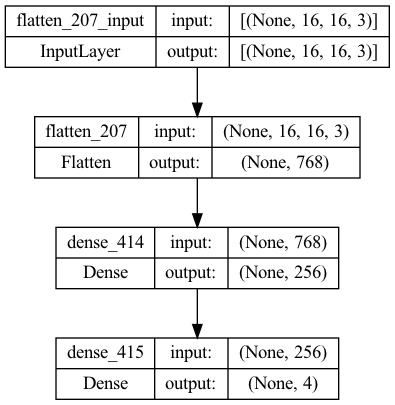

In [110]:
import tensorflow as tf

tuned_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM), 
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.017220969945742858)
tuned_model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['categorical_accuracy'])
tuned_model.summary()

tf.keras.utils.plot_model(tuned_model, show_shapes=True)



In [130]:
test_data['cellType'] = test_data['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
       directory='patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(16, 16),
        batch_size=batch_size,
        class_mode='categorical')

tuned_history = tuned_model.fit(train_generator, validation_data=validation_generator, epochs=50, verbose=0)

tuned_model.evaluate(test_generator)

Found 1980 validated image filenames belonging to 4 classes.
1980/1980 [==============================] - 3s 1ms/step - loss: 1.2105 - categorical_accuracy: 0.5455


[1.2105364799499512, 0.5454545617103577]

In [131]:
label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}

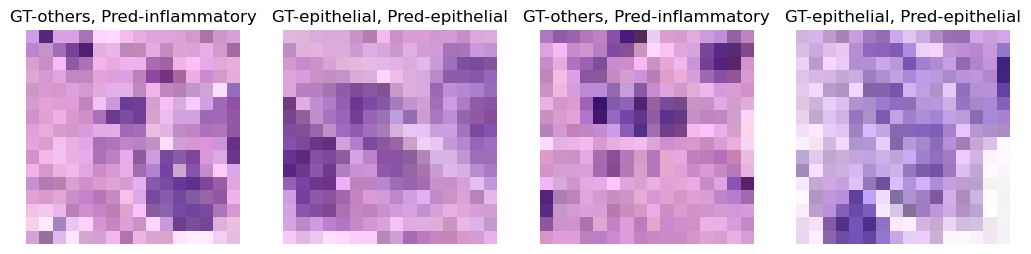

In [133]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = tuned_model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
        else:
            break
        
        plt.axis('off')
  

In [128]:
# Evaluating the model on the test data
test_loss, test_accuracy = tuned_model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


1980/1980 [==============================] - 3s 1ms/step - loss: 0.9660 - categorical_accuracy: 0.6581
Test Loss: 0.9659643173217773
Test Accuracy: 0.6580808162689209


1980/1980 [==============================] - 3s 1ms/step - loss: 1.2105 - categorical_accuracy: 0.5455
Test Loss: 1.2105363607406616
Test Accuracy: 0.5454545617103577
1980/1980 [==============================] - 2s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.03      0.05       391
           1       0.25      0.65      0.36       496
           2       0.41      0.32      0.36       791
           3       0.08      0.01      0.02       302

    accuracy                           0.30      1980
   macro avg       0.24      0.25      0.20      1980
weighted avg       0.29      0.30      0.25      1980



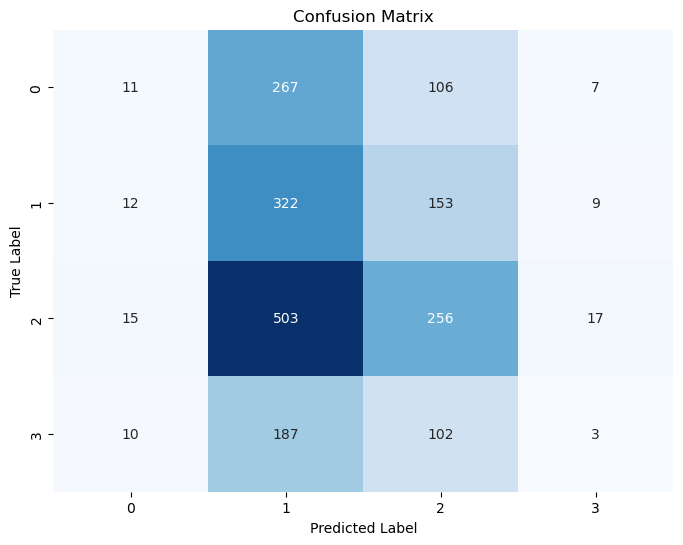

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the model on the test data
test_loss, test_accuracy = tuned_model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Generate predictions for the test data
y_pred = tuned_model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_labels)

# Print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_labels))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


The confusion matrix is a table that is often used to describe the performance of a classification model. It provides a detailed breakdown of the model's predictions and the actual class labels.

In the context of the confusion matrix, the rows represent the true labels of the data points, and the columns represent the predicted labels. Each cell in the matrix represents the count or frequency of data points that belong to a specific combination of true and predicted labels.

The confusion matrix helps in evaluating the performance of a classification model by providing the following information:

True Positives (TP): The number of data points that are correctly predicted as positive (correctly classified).
True Negatives (TN): The number of data points that are correctly predicted as negative (correctly classified).
False Positives (FP): The number of data points that are incorrectly predicted as positive (incorrectly classified).
False Negatives (FN): The number of data points that are incorrectly predicted as negative (incorrectly classified).
The confusion matrix allows you to analyze the model's performance in terms of accuracy, precision, recall, and other classification metrics. It helps identify if the model is making specific types of errors, such as misclassifying certain classes more frequently.

By visualizing the confusion matrix, you can easily observe patterns and gain insights into the model's strengths and weaknesses. It can help you understand which classes are being confused with each other and identify potential areas for improvement in your classification model.




